### Import packages

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import transpile

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as sampler, EstimatorV2 as estimator
from qiskit.visualization import plot_histogram

### Functions definitions

In [2]:
def f(h_A,h_B,k):
    return (4*k**2/((h_A+h_B)**2+1))**(-1/2)

def Fplus(h_A,h_B,k):
    return (1+(h_A+h_B)/(4*k**2+(h_A+h_B)**2)**(1/2))**(1/2)

def Fminus(h_A,h_B,k):
    return (1-(h_A+h_B)/(4*k**2+(h_A+h_B)**2)**(1/2))**(1/2)

def F2plus(h_A,h_B,k):
    return (1+h_B/(h_B**2+4*k**2)**1/2)**(1/2)

def F2minus(h_A,h_B,k):
    return (1-h_B/(h_B**2+4*k**2)**1/2)**(1/2)

### Define unitary matrices

In [3]:
def U_rotV(h_A, h_B, k):
    U = (1/2)**(1/2) * np.array([ 
        [F2plus(h_A,h_B,k), F2minus(h_A,h_B,k), 0, 0],
        [0, 0, -F2plus(h_A,h_B,k), F2minus(h_A,h_B,k)],
        [0, 0, F2minus(h_A,h_B,k), F2plus(h_A,h_B,k)],
        [-F2minus(h_A,h_B,k), F2plus(h_A,h_B,k), 0, 0]
    ]) 
    return U

def U_diag(h_A, h_B, k): 
    U =  (1/2)**(1/2) * np.array([
        [0, Fplus(h_A,h_B,k), Fminus(h_A,h_B,k), 0],
        [Fminus(h_A,h_B,k), 0, 0, -Fplus(h_A,h_B,k)],
        [Fplus(h_A,h_B,k), 0, 0, Fminus(h_A,h_B,k)],
        [0, -Fminus(h_A,h_B,k), Fplus(h_A,h_B,k), 0]
    ])
    return U

def Y(h_A,h_B,k):
    U = -(1/2)**(1/2) * np.array([
        [Fplus(h_A,h_B,k), Fminus(h_A,h_B,k)],
        [-Fminus(h_A,h_B,k), Fplus(h_A,h_B,k)]
    ]) 
    return U

### Create circuits

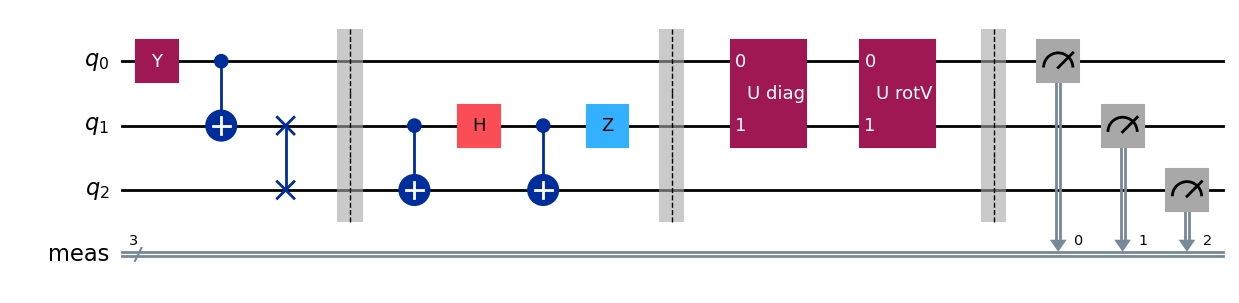

In [4]:
def QET_RMN_Z(h_A,h_B,k):
    
    qc = QuantumCircuit(3)

    # Prepare ground state
    #theta = -np.arcsin((1/2)**(1/2) * Fminus(h_A,h_B,k))
    #qc.ry(2*theta,0)

    qc.unitary(Y(h_A,h_B,k), 0, label='Y')
    qc.cx(0,1)
    qc.swap(1, 2)

    qc.barrier()

    # Auxiliary qubit An gains information of A
    qc.cx(1,2)
    qc.h(1)
    qc.cx(1,2)
    qc.z(1)

    qc.barrier()

    # Energy teleportation
    qc.unitary(U_diag(h_A,h_B,k), [0,1], label='U diag')
    qc.unitary(U_rotV(h_A,h_B,k), [0,1], label='U rotV')
    
    # mesurements
    qc.measure_all()
    return qc

qc = QET_RMN_Z(1,0.4,1)
qc.draw('mpl')

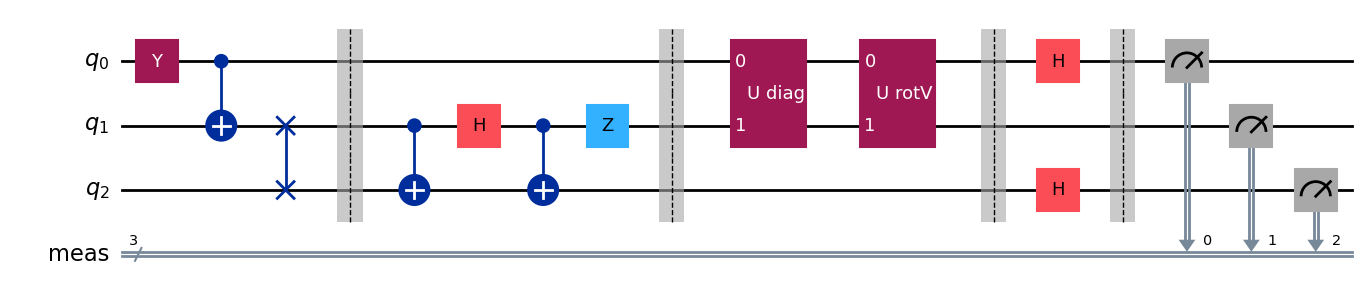

In [5]:
def QET_RMN_XX(h_A,h_B,k):
    
    qc = QuantumCircuit(3)

    # Prepare ground state
    #theta = -np.arcsin((1/2)**(1/2) * Fminus(h_A,h_B,k))
    #qc.ry(2*theta,0)
    
    qc.unitary(Y(h_A,h_B,k), 0, label='Y')
    qc.cx(0,1)
    qc.swap(1, 2)

    qc.barrier()

    # Auxiliary qubit An gains information of A
    qc.cx(1,2)
    qc.h(1)
    qc.cx(1,2)
    qc.z(1)

    qc.barrier()

    # Energy teleportation
    qc.unitary(U_diag(h_A,h_B,k), [0,1], label='U diag')
    qc.unitary(U_rotV(h_A,h_B,k), [0,1], label='U rotV')
    
    qc.barrier()

    # mesurements
    qc.h(0)
    qc.h(2)
    qc.measure_all()
    return qc

qc = QET_RMN_XX(1,0.4,1)
qc.draw('mpl')

In [6]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h_A=1;h_B=1;k=1
n_shots = 100000

# Generate circuit
qc1 = QET_RMN_Z(h_A,h_B,k)
qc_A = transpile(qc1, simulator, optimization_level=3)
qc2 = QET_RMN_XX(h_A,h_B,k)
qc_B = transpile(qc2, simulator, optimization_level=3)

# Run job with Sampler
jobA = sampler().run([qc_A], shots=n_shots)
jobB = sampler().run([qc_B], shots=n_shots)

In [7]:
from qiskit.quantum_info import SparsePauliOp 

# Initiate simulator
simulator = AerSimulator()

# Parameters
h_A=1;h_B=1;k=1

# observables
observables = [SparsePauliOp('IIZ', -h_B) , SparsePauliOp('XIX', 2*k)]

# Generate circuit
qc1 = QET_RMN_Z(h_A,h_B,k)
qc_T = transpile(qc1, simulator, optimization_level=3)

job1 = estimator().run([(qc_T, observables[0])])
job2 = estimator().run([(qc_T, observables[1])])

In [8]:
result = job1.result()
H = result[0].data.evs
result = job2.result()
V = result[0].data.evs

H = H + h_B*f(h_A, h_B, k)
V = V + (4*k**2)/(h_A + h_B) * f(h_A,h_B,k)

print(H)
print(V)

1.069205863749895
2.23606797749979


In [9]:
# Extract results
result = jobA.result()[0]
counts = result.data.meas.get_counts()

# Energys
ene_B = f(h_A,h_B,k)*h_B

# Error arrays
error_B = []

# Calculate energies and errors
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_B += -h_B*(-1)**int(bit_string[0])*count/n_shots

        for i in range(count):
            error_B.append(-h_B*(-1)**int(bit_string[0]))

# Print results
print("H_B =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))

#plot_histogram(counts, title="aer_simulator H")

H_B = 1.1193939887498947 ± 0.003162274735692647


In [10]:
# Extract results
result = jobB.result()[0]
counts = result.data.meas.get_counts()

# Energies
ene_V = f(h_A,h_B,k)*(4*k**2)/(h_A + h_B)

# Error arrays
error_V = []

# Calculate energies
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[2])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[2]))

# Print results
print("V =",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

#plot_histogram(counts, title='aer_simulator V')

V = 3.6523479774997902 ± 0.004465591743095196
